# Jaywalking Summons Granger Causality Analysis

This Jupyter Notebook performs a Granger causality analysis to investigate the relationship between jaywalking summonses and jaywalking collisions. The analysis aims to determine whether the number of jaywalking summonses can predict the number of jaywalking collisions and vice versa.

## Overview

The notebook is divided into several sections:

1. **Data Preparation**: 
   - Load the dataset containing quarterly data on jaywalking collisions and summonses.
   - Filter out outliers based on z-scores to ensure the analysis is not skewed by extreme values.

2. **Data Visualization**:
   - Plot the original and transformed data to visualize trends and relationships.
   - Use Matplotlib to create line plots for the pedestrian share of total collisions and jaywalking summonses over time.
   - Rotate x-tick labels for better readability and set the maximum number of x-ticks.

3. **Granger Causality Test**:
   - Perform the Granger causality test to determine if one time series can predict another.
   - In order to perform GCT the data is transformed to be stationary using detrending by subtracting the moving average from the original data
   - Interpret the results to understand the causal relationship between jaywalking summonses and collisions.

## How It Works

- **Data Loading**: The dataset is loaded into a DataFrame, and relevant columns are extracted for analysis.
- **Outlier Removal**: Outliers are filtered out by keeping data points within three standard deviations of the mean.
- **Plotting**: The data is plotted to visualize trends. The plots include the pedestrian share of total collisions and jaywalking summonses over different quarters.
- **Granger Causality Test**: The test is conducted to check if past values of one variable can predict the current values of another variable.

## Usage

Run each cell sequentially to perform the analysis. Ensure that the required libraries (e.g., Matplotlib, NumPy) are installed in your environment.

## Dependencies

- Matplotlib
- NumPy
- Pandas


In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
from scipy.stats import zscore
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller, kpss

In [2]:
def test_stationarity(timeseries):
    # ADF Test
    print("Results of Dickey-Fuller Test:")
    adf_result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % adf_result[0])
    print('p-value: %f' % adf_result[1])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print('\t%s: %.3f' % (key, value))
    if adf_result[1] <= 0.05:
        print("Series is stationary according to ADF test")
    else:
        print("Series is not stationary according to ADF test")

    # KPSS Test
    print("\nResults of KPSS Test:")
    kpss_result = kpss(timeseries, regression='c')
    print('KPSS Statistic: %f' % kpss_result[0])
    print('p-value: %f' % kpss_result[1])
    print('Critical Values:')
    for key, value in kpss_result[3].items():
        print('\t%s: %.3f' % (key, value))
    if kpss_result[1] >= 0.05:
        print("Series is stationary according to KPSS test")
    else:
        print("Series is not stationary according to KPSS test")

In [3]:
# jaywalking criminal summonses by quarter

jaywalking_crim_summonses_quarterly = pd.read_csv('../data/output/jaywalking_crim_summonses_quarterly.csv')

In [4]:
# uploading crash data (has data on persons involved in collisions)

collisions_person_dataset = pd.read_csv('https://data.cityofnewyork.us/resource/f55k-p6yu.csv?$limit=9999999')

In [5]:
collisions_person_dataset['crash_date'] = pd.to_datetime(collisions_person_dataset['crash_date'])

# creating quarter column 
collisions_person_dataset['quarter'] = collisions_person_dataset['crash_date'].dt.quarter.astype(str) 
collisions_person_dataset['quarter'] = 'Q' + collisions_person_dataset['quarter']
collisions_person_dataset['year'] = collisions_person_dataset['crash_date'].dt.year.astype(str)
collisions_person_dataset['quarter'] = collisions_person_dataset['year'] + ' ' + collisions_person_dataset['quarter']

In [6]:
# will be used to normalize

collisions_per_quarter = collisions_person_dataset.groupby('quarter').count()[['unique_id']].rename(columns={'unique_id':'total_collisions'})

In [7]:
# creating pedestrian collisions dataset

pedestrian_collisions = collisions_person_dataset[collisions_person_dataset['person_type'] == 'Pedestrian']
pedestrian_collisions['pedestrians_killed'] = np.where(pedestrian_collisions['person_injury'] == 'Killed', 1, 0)
pedestrian_collisions['pedestrians_injured'] = np.where(pedestrian_collisions['person_injury'] == 'Injured', 1, 0)
pedestrian_collisions['pedestrian_ksi'] = np.where(pedestrian_collisions['person_injury'].isin(['Injured', 'Killed']), 1, 0)

/var/folders/pl/smldwrws5sv13t7rs8_2y98htg6kdq/T/ipykernel_21376/1898355313.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pedestrian_collisions['pedestrians_killed'] = np.where(pedestrian_collisions['person_injury'] == 'Killed', 1, 0)
/var/folders/pl/smldwrws5sv13t7rs8_2y98htg6kdq/T/ipykernel_21376/1898355313.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pedestrian_collisions['pedestrians_injured'] = np.where(pedestrian_collisions['person_injury'] == 'Injured', 1, 0)
/var/folders/pl/smldwrws5sv1

In [8]:
# will be used to normalize

ped_collisions_per_quarter = pedestrian_collisions.groupby('quarter').count()[['unique_id']].rename(columns={'unique_id':'pedestrian_collisions'})

In [9]:
# important to note that 32% of pedestrian collisions have 'ped_action' listed as null
# this means that subsetting the dataset based on 'ped_action' entries that indicate jaywalking will likely result in false negatives
# will run regression on both all pedestrian collisions AND all jaywalking collisions in case the results differ

round((100*pedestrian_collisions['ped_action'].value_counts(dropna=False) / len(pedestrian_collisions['ped_action'])),2)

ped_action
NaN                                                32.30
Crossing With Signal                               25.75
Crossing, No Signal, or Crosswalk                  11.70
Crossing, No Signal, Marked Crosswalk               5.88
Other Actions in Roadway                            5.15
Crossing Against Signal                             4.70
Unknown                                             3.22
Not in Roadway                                      3.20
Does Not Apply                                      2.75
Emerging from in Front of/Behind Parked Vehicle     2.16
Working in Roadway                                  1.01
Getting On/Off Vehicle Other Than School Bus        0.93
Riding/Walking Along Highway With Traffic           0.47
Playing in Roadway                                  0.37
Riding/Walking Along Highway Against Traffic        0.18
Pushing/Working on Car                              0.16
Going to/From Stopped School Bus                    0.06
Name: count, dtype: 

In [10]:
# with that in mind...
# narrowing down to just crashes involving jaywalkers (based on available data)
    # 1) crossing without a signal AND not in a crosswalk
    # 2) crossing in a crosswalk without a signal
    # 3) crossing without a signal

jaywalking_collisions = pedestrian_collisions[pedestrian_collisions['ped_action'].isin(['Crossing, No Signal, or Crosswalk', 'Crossing, No Signal, Marked Crosswalk', 'Crossing Against Signal'])]

In [11]:
# investigating where these types of crashes occur

jaywalking_collisions[jaywalking_collisions['ped_action'] == 'Crossing, No Signal, or Crosswalk'][['ped_location']].value_counts(dropna=False)

ped_location                                             
Pedestrian/Bicyclist/Other Pedestrian Not at Intersection    11277
Pedestrian/Bicyclist/Other Pedestrian at Intersection         3542
Does Not Apply                                                 244
Unknown                                                        208
NaN                                                              9
Name: count, dtype: int64

In [12]:
# investigating where these types of crashes occur

jaywalking_collisions[jaywalking_collisions['ped_action'] == 'Crossing, No Signal, Marked Crosswalk'][['ped_location']].value_counts(dropna=False)

ped_location                                             
Pedestrian/Bicyclist/Other Pedestrian at Intersection        6741
Pedestrian/Bicyclist/Other Pedestrian Not at Intersection     806
Does Not Apply                                                 74
Unknown                                                        59
NaN                                                             6
Name: count, dtype: int64

In [13]:
# investigating where these types of crashes occur

jaywalking_collisions[jaywalking_collisions['ped_action'] == 'Crossing Against Signal'][['ped_location']].value_counts(dropna=False)

ped_location                                             
Pedestrian/Bicyclist/Other Pedestrian at Intersection        4902
Pedestrian/Bicyclist/Other Pedestrian Not at Intersection    1118
Unknown                                                        72
Does Not Apply                                                 49
NaN                                                             3
Name: count, dtype: int64

In [14]:
# grouping by quater
# pre-2016 Q2 seems badly affected by NaN issue
# should just look at 2016 and beyond for jaywalking dataset

jaywalking_collisions_per_quarter = jaywalking_collisions.groupby('quarter').agg({'unique_id': 'count', 'pedestrians_injured': 'sum', 'pedestrians_killed': 'sum', 'pedestrian_ksi': 'sum'}).rename(columns={'unique_id':'jaywalking_collisions'})
jaywalking_collisions_per_quarter = jaywalking_collisions_per_quarter.merge(ped_collisions_per_quarter, on='quarter', how='left')
jaywalking_collisions_per_quarter = jaywalking_collisions_per_quarter.merge(collisions_per_quarter, on='quarter', how='left')
jaywalking_collisions_per_quarter['jay_share_collisions'] = round((100*jaywalking_collisions_per_quarter['jaywalking_collisions'] / jaywalking_collisions_per_quarter['total_collisions']),2)
jaywalking_collisions_per_quarter['ped_share_collisions'] = round((100*jaywalking_collisions_per_quarter['pedestrian_collisions'] / jaywalking_collisions_per_quarter['total_collisions']),2)
jaywalking_collisions_per_quarter = jaywalking_collisions_per_quarter.merge(jaywalking_crim_summonses_quarterly, on='quarter', how='left')


In [15]:
# eliminating pre-2016 quarters (plus not including 2024 Q3 because it's not over)

jaywalking_collisions_per_quarter = jaywalking_collisions_per_quarter.loc[5:38]

In [16]:
# creating df without outliers

# identify outliers using Z-score
jaywalking_collisions_per_quarter['zscore_jaywalking_collisions'] = zscore(jaywalking_collisions_per_quarter['jaywalking_collisions'])
jaywalking_collisions_per_quarter['zscore_pedestrian_collisions'] = zscore(jaywalking_collisions_per_quarter['pedestrian_collisions'])
jaywalking_collisions_per_quarter['zscore_total_collisions'] = zscore(jaywalking_collisions_per_quarter['total_collisions'])
jaywalking_collisions_per_quarter['zscore_pedestrian_ksi'] = zscore(jaywalking_collisions_per_quarter['pedestrian_ksi'])
jaywalking_collisions_per_quarter['zscore_jay_share_collisions'] = zscore(jaywalking_collisions_per_quarter['jay_share_collisions'])
jaywalking_collisions_per_quarter['zscore_ped_share_collisions'] = zscore(jaywalking_collisions_per_quarter['ped_share_collisions'])
jaywalking_collisions_per_quarter['zscore_total_summonses'] = zscore(jaywalking_collisions_per_quarter['total_summonses'])


In [17]:
# jaywalking collisions vs jaywalking summonses

# filter out outliers (keeping those within 3 standard deviations)
df_no_outliers = jaywalking_collisions_per_quarter[(np.abs(jaywalking_collisions_per_quarter['zscore_total_summonses']) < 3) & (np.abs(jaywalking_collisions_per_quarter['zscore_jaywalking_collisions']) < 3)]

# check if there are outliers
len(df_no_outliers) == len(jaywalking_collisions_per_quarter)

True

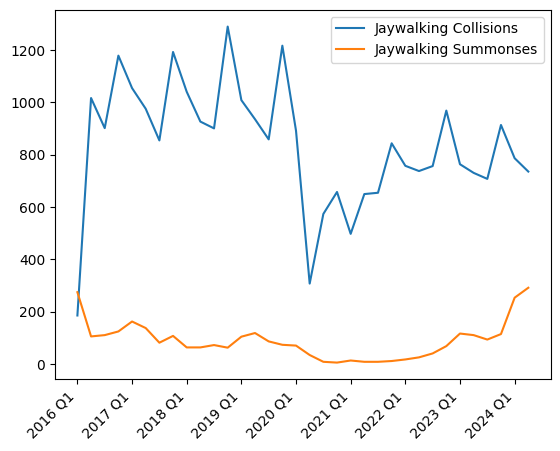

In [18]:
# since there are no outliers, proceed

# plot lines 

quarter = jaywalking_collisions_per_quarter['quarter']
jaywalking_collisions = jaywalking_collisions_per_quarter['jaywalking_collisions']
jaywalking_summonses = jaywalking_collisions_per_quarter['total_summonses']

plt.plot(quarter, jaywalking_collisions, label = "Jaywalking Collisions") 
plt.plot(quarter, jaywalking_summonses, label = "Jaywalking Summonses") 

# Set maximum number of x-ticks
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=10))

# rotate x-tick labels for better readability
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.legend() 
plt.show()

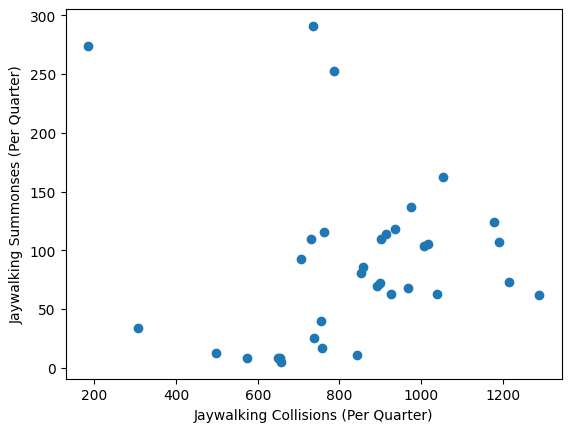

In [19]:
# scatter plot

# add axis labels
plt.xlabel('Jaywalking Collisions (Per Quarter)')
plt.ylabel('Jaywalking Summonses (Per Quarter)')

plt.scatter(jaywalking_collisions, jaywalking_summonses)
plt.show()

In [20]:
# pedestrian collisions vs jaywalking summonses

# filter out outliers (keeping those within 3 standard deviations)
df_no_outliers = jaywalking_collisions_per_quarter[(np.abs(jaywalking_collisions_per_quarter['zscore_total_summonses']) < 3) & (np.abs(jaywalking_collisions_per_quarter['zscore_pedestrian_collisions']) < 3)]

# check if there are outliers
len(df_no_outliers) == len(jaywalking_collisions_per_quarter)

True

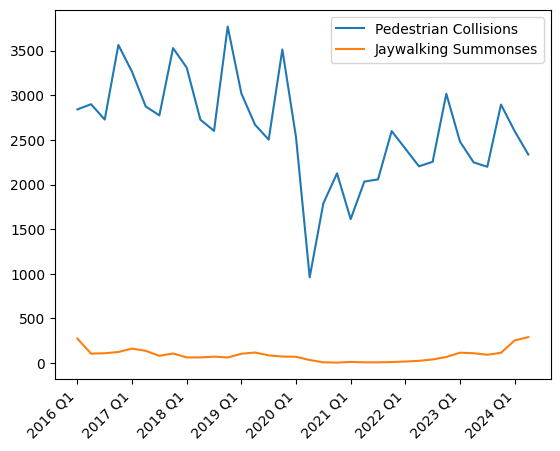

In [21]:
# since there are no outliers, proceed

# plot lines 

pedestrian_collisions = jaywalking_collisions_per_quarter['pedestrian_collisions']

plt.plot(quarter, pedestrian_collisions, label = "Pedestrian Collisions") 
plt.plot(quarter, jaywalking_summonses, label = "Jaywalking Summonses") 

# set maximum number of x-ticks
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=10))

# rotate x-tick labels for better readability
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.legend() 
plt.show()

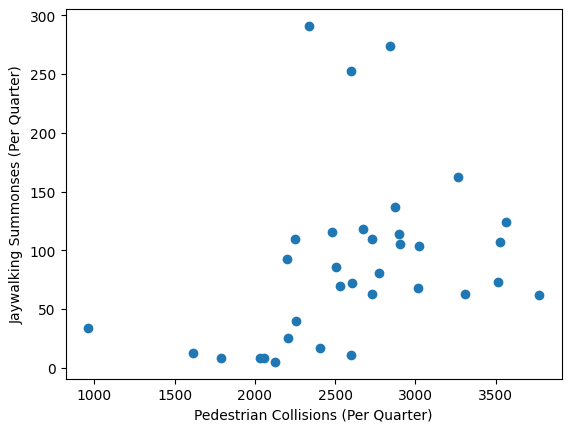

In [22]:
# scatter plot

# add axis labels
plt.xlabel('Pedestrian Collisions (Per Quarter)')
plt.ylabel('Jaywalking Summonses (Per Quarter)')

plt.scatter(pedestrian_collisions, jaywalking_summonses)
plt.show()

In [23]:
# jaywalking share of total collisions vs jaywalking summonses

# filter out outliers (keeping those within 3 standard deviations)
df_no_outliers = jaywalking_collisions_per_quarter[(np.abs(jaywalking_collisions_per_quarter['zscore_total_summonses']) < 3) & (np.abs(jaywalking_collisions_per_quarter['zscore_jay_share_collisions']) < 3)]

# check if there are outliers
len(df_no_outliers) == len(jaywalking_collisions_per_quarter)

True

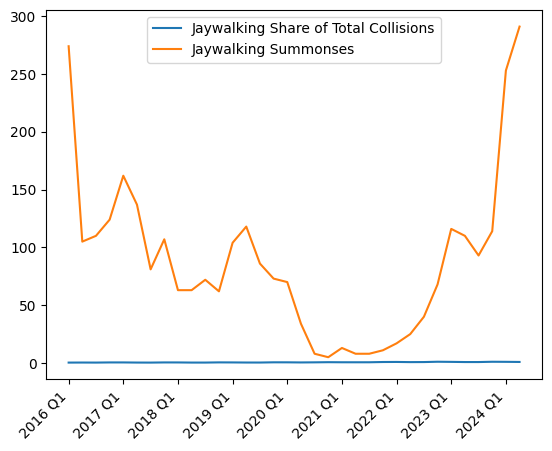

In [24]:
# since there are no outliers, proceed

# plot lines 

jay_share_collisions = jaywalking_collisions_per_quarter['jay_share_collisions']

plt.plot(quarter, jay_share_collisions, label = "Jaywalking Share of Total Collisions") 
plt.plot(quarter, jaywalking_summonses, label = "Jaywalking Summonses") 

# set maximum number of x-ticks
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=10))

# rotate x-tick labels for better readability
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.legend() 
plt.show()

In [25]:
jaywalking_collisions_per_quarter

,quarter,jaywalking_collisions,pedestrians_injured,pedestrians_killed,pedestrian_ksi,pedestrian_collisions,total_collisions,jay_share_collisions,ped_share_collisions,total_summonses,zscore_jaywalking_collisions,zscore_pedestrian_collisions,zscore_total_collisions,zscore_pedestrian_ksi,zscore_jay_share_collisions,zscore_ped_share_collisions,zscore_total_summonses
5,2016 Q1,185,172,1,173,2843,53222,0.35,5.34,274.0,-2.776606,0.388810,-1.361007,-2.787728,-1.214941,3.558615,2.605342
6,2016 Q2,1016,942,12,954,2901,253589,0.40,1.14,105.0,0.763567,0.488425,1.355341,0.814127,-0.992136,-0.980646,0.225705
7,2016 Q3,901,816,19,835,2729,250810,0.36,1.09,110.0,0.273651,0.193016,1.317666,0.265317,-1.170380,-1.034684,0.296109
8,2016 Q4,1178,1071,19,1090,3565,242744,0.49,1.47,124.0,1.453709,1.628841,1.208316,1.441339,-0.591088,-0.623989,0.493238
9,2017 Q1,1054,953,16,969,3264,216791,0.49,1.51,162.0,0.925452,1.111875,0.856475,0.883305,-0.591088,-0.580758,1.028304
10,2017 Q2,975,875,9,884,2876,255096,0.38,1.13,137.0,0.588901,0.445488,1.375771,0.491298,-1.081258,-0.991453,0.676287
11,2017 Q3,854,776,20,796,2776,244730,0.35,1.13,81.0,0.073425,0.273738,1.235240,0.085455,-1.214941,-0.991453,-0.112231
12,2017 Q4,1192,1097,14,1111,3530,245158,0.49,1.44,107.0,1.513351,1.568728,1.241043,1.538188,-0.591088,-0.656413,0.253867
13,2018 Q1,1040,925,9,934,3311,215983,0.48,1.53,63.0,0.865810,1.192597,0.845521,0.721890,-0.635649,-0.559143,-0.365684
14,2018 Q2,926,845,14,859,2728,246993,0.37,1.10,63.0,0.380155,0.191298,1.265920,0.376001,-1.125819,-1.023877,-0.365684


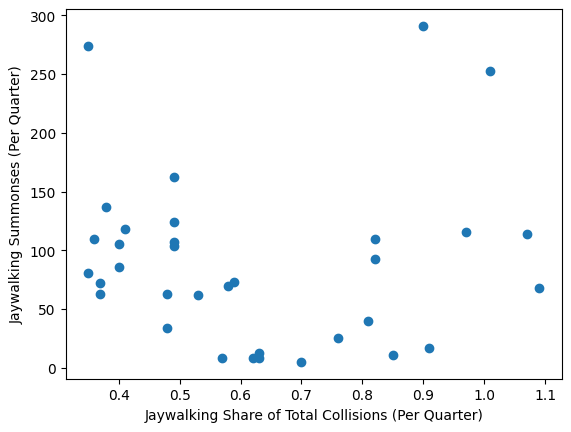

In [26]:
# scatter plot

# add axis labels
plt.xlabel('Jaywalking Share of Total Collisions (Per Quarter)')
plt.ylabel('Jaywalking Summonses (Per Quarter)')

plt.scatter(jay_share_collisions, jaywalking_summonses)
plt.show()

In [27]:
test_stationarity(jaywalking_collisions_per_quarter['total_summonses'])

Results of Dickey-Fuller Test:
ADF Statistic: -1.901596
p-value: 0.331311
Critical Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616
Series is not stationary according to ADF test

Results of KPSS Test:
KPSS Statistic: 0.224429
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Series is stationary according to KPSS test


/var/folders/pl/smldwrws5sv13t7rs8_2y98htg6kdq/T/ipykernel_21376/3696343732.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(timeseries, regression='c')


In [28]:
test_stationarity(jaywalking_collisions_per_quarter['ped_share_collisions'])

Results of Dickey-Fuller Test:
ADF Statistic: 1.001539
p-value: 0.994282
Critical Values:
	1%: -3.670
	5%: -2.964
	10%: -2.621
Series is not stationary according to ADF test

Results of KPSS Test:
KPSS Statistic: 0.542719
p-value: 0.032045
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Series is not stationary according to KPSS test


In [29]:
# Calculate moving average
x_ma = jaywalking_collisions_per_quarter['total_summonses'].rolling(window=2).mean()

# Detrend the data by subtracting the moving average from the original data
x_detrended = jaywalking_collisions_per_quarter['total_summonses'] - x_ma

In [30]:
test_stationarity(x_detrended.dropna())

Results of Dickey-Fuller Test:
ADF Statistic: -3.711767
p-value: 0.003951
Critical Values:
	1%: -3.661
	5%: -2.961
	10%: -2.619
Series is stationary according to ADF test

Results of KPSS Test:
KPSS Statistic: 0.655230
p-value: 0.017615
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Series is not stationary according to KPSS test


In [31]:
# Calculate moving average
y_ma = jaywalking_collisions_per_quarter['ped_share_collisions'].rolling(window=2).mean()

# Detrend the data by subtracting the moving average from the original data
y_detrended = jaywalking_collisions_per_quarter['ped_share_collisions'] - y_ma

In [32]:
test_stationarity(y_detrended.dropna())

Results of Dickey-Fuller Test:
ADF Statistic: -10.798867
p-value: 0.000000
Critical Values:
	1%: -3.670
	5%: -2.964
	10%: -2.621
Series is stationary according to ADF test

Results of KPSS Test:
KPSS Statistic: 0.332266
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Series is stationary according to KPSS test


/var/folders/pl/smldwrws5sv13t7rs8_2y98htg6kdq/T/ipykernel_21376/3696343732.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(timeseries, regression='c')


In [33]:
jaywalking_collisions_per_quarter

,quarter,jaywalking_collisions,pedestrians_injured,pedestrians_killed,pedestrian_ksi,pedestrian_collisions,total_collisions,jay_share_collisions,ped_share_collisions,total_summonses,zscore_jaywalking_collisions,zscore_pedestrian_collisions,zscore_total_collisions,zscore_pedestrian_ksi,zscore_jay_share_collisions,zscore_ped_share_collisions,zscore_total_summonses
5,2016 Q1,185,172,1,173,2843,53222,0.35,5.34,274.0,-2.776606,0.388810,-1.361007,-2.787728,-1.214941,3.558615,2.605342
6,2016 Q2,1016,942,12,954,2901,253589,0.40,1.14,105.0,0.763567,0.488425,1.355341,0.814127,-0.992136,-0.980646,0.225705
7,2016 Q3,901,816,19,835,2729,250810,0.36,1.09,110.0,0.273651,0.193016,1.317666,0.265317,-1.170380,-1.034684,0.296109
8,2016 Q4,1178,1071,19,1090,3565,242744,0.49,1.47,124.0,1.453709,1.628841,1.208316,1.441339,-0.591088,-0.623989,0.493238
9,2017 Q1,1054,953,16,969,3264,216791,0.49,1.51,162.0,0.925452,1.111875,0.856475,0.883305,-0.591088,-0.580758,1.028304
10,2017 Q2,975,875,9,884,2876,255096,0.38,1.13,137.0,0.588901,0.445488,1.375771,0.491298,-1.081258,-0.991453,0.676287
11,2017 Q3,854,776,20,796,2776,244730,0.35,1.13,81.0,0.073425,0.273738,1.235240,0.085455,-1.214941,-0.991453,-0.112231
12,2017 Q4,1192,1097,14,1111,3530,245158,0.49,1.44,107.0,1.513351,1.568728,1.241043,1.538188,-0.591088,-0.656413,0.253867
13,2018 Q1,1040,925,9,934,3311,215983,0.48,1.53,63.0,0.865810,1.192597,0.845521,0.721890,-0.635649,-0.559143,-0.365684
14,2018 Q2,926,845,14,859,2728,246993,0.37,1.10,63.0,0.380155,0.191298,1.265920,0.376001,-1.125819,-1.023877,-0.365684


In [34]:
jaywalking_collisions_per_quarter['y_detrended'] = y_detrended
jaywalking_collisions_per_quarter['x_detrended'] = x_detrended

In [35]:
jaywalking_collisions_per_quarter 

,quarter,jaywalking_collisions,pedestrians_injured,pedestrians_killed,pedestrian_ksi,pedestrian_collisions,total_collisions,jay_share_collisions,ped_share_collisions,total_summonses,zscore_jaywalking_collisions,zscore_pedestrian_collisions,zscore_total_collisions,zscore_pedestrian_ksi,zscore_jay_share_collisions,zscore_ped_share_collisions,zscore_total_summonses,y_detrended,x_detrended
5,2016 Q1,185,172,1,173,2843,53222,0.35,5.34,274.0,-2.776606,0.388810,-1.361007,-2.787728,-1.214941,3.558615,2.605342,NaN,NaN
6,2016 Q2,1016,942,12,954,2901,253589,0.40,1.14,105.0,0.763567,0.488425,1.355341,0.814127,-0.992136,-0.980646,0.225705,-2.100,-84.5
7,2016 Q3,901,816,19,835,2729,250810,0.36,1.09,110.0,0.273651,0.193016,1.317666,0.265317,-1.170380,-1.034684,0.296109,-0.025,2.5
8,2016 Q4,1178,1071,19,1090,3565,242744,0.49,1.47,124.0,1.453709,1.628841,1.208316,1.441339,-0.591088,-0.623989,0.493238,0.190,7.0
9,2017 Q1,1054,953,16,969,3264,216791,0.49,1.51,162.0,0.925452,1.111875,0.856475,0.883305,-0.591088,-0.580758,1.028304,0.020,19.0
10,2017 Q2,975,875,9,884,2876,255096,0.38,1.13,137.0,0.588901,0.445488,1.375771,0.491298,-1.081258,-0.991453,0.676287,-0.190,-12.5
11,2017 Q3,854,776,20,796,2776,244730,0.35,1.13,81.0,0.073425,0.273738,1.235240,0.085455,-1.214941,-0.991453,-0.112231,0.000,-28.0
12,2017 Q4,1192,1097,14,1111,3530,245158,0.49,1.44,107.0,1.513351,1.568728,1.241043,1.538188,-0.591088,-0.656413,0.253867,0.155,13.0
13,2018 Q1,1040,925,9,934,3311,215983,0.48,1.53,63.0,0.865810,1.192597,0.845521,0.721890,-0.635649,-0.559143,-0.365684,0.045,-22.0
14,2018 Q2,926,845,14,859,2728,246993,0.37,1.10,63.0,0.380155,0.191298,1.265920,0.376001,-1.125819,-1.023877,-0.365684,-0.215,0.0


In [36]:
df = pd.DataFrame({'ped_share_collisions': y_detrended.dropna(),'total_summonses': x_detrended.dropna()})

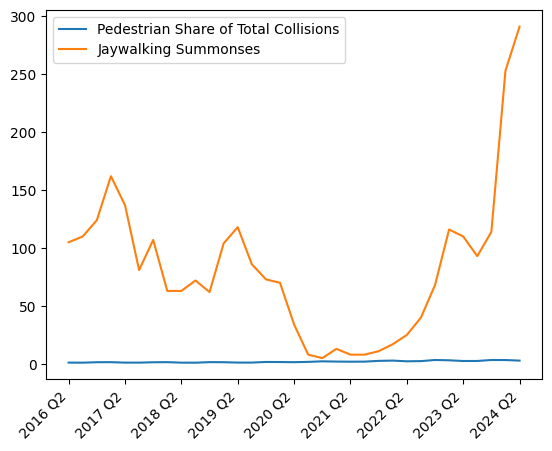

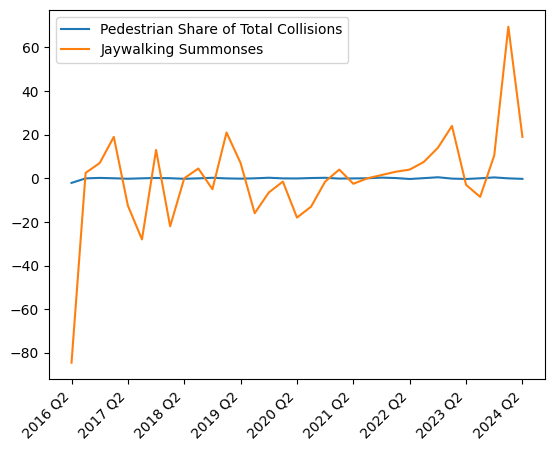

In [37]:
#Plotting original data

quarter = jaywalking_collisions_per_quarter['quarter'][1:]
jaywalking_summonses = jaywalking_collisions_per_quarter['total_summonses'][1:]
ped_share_collisions = jaywalking_collisions_per_quarter['ped_share_collisions'][1:]

plt.plot(quarter, ped_share_collisions, label = "Pedestrian Share of Total Collisions") 
plt.plot(quarter, jaywalking_summonses, label = "Jaywalking Summonses") 

# set maximum number of x-ticks
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=10))

# rotate x-tick labels for better readability
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.legend() 
plt.show()

#Plotting transformed data

quarter = jaywalking_collisions_per_quarter['quarter'][1:]
jaywalking_summonses = df['total_summonses']
ped_share_collisions = df['ped_share_collisions']

plt.plot(quarter, ped_share_collisions, label = "Pedestrian Share of Total Collisions") 
plt.plot(quarter, jaywalking_summonses, label = "Jaywalking Summonses") 

# set maximum number of x-ticks
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=10))

# rotate x-tick labels for better readability
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.legend() 
plt.show()

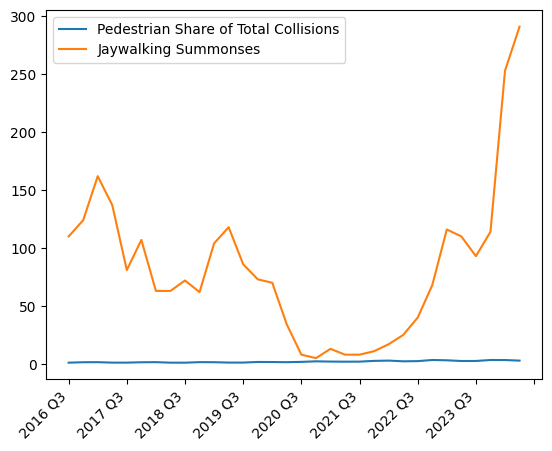

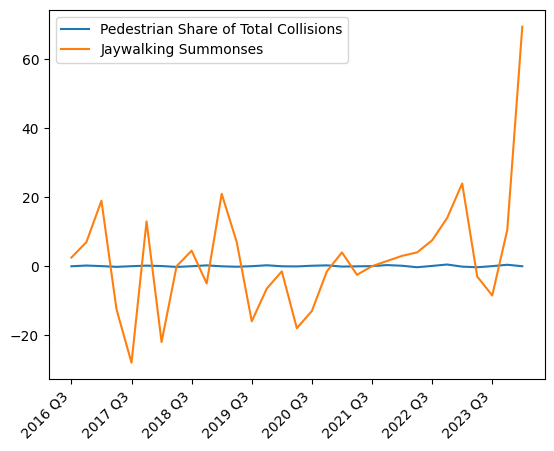

In [38]:
# Result without 2016 Q2 and 2024 Q2

#Plotting original data

quarter = jaywalking_collisions_per_quarter['quarter'][2:]
jaywalking_summonses = jaywalking_collisions_per_quarter['total_summonses'][2:]
ped_share_collisions = jaywalking_collisions_per_quarter['ped_share_collisions'][2:]

plt.plot(quarter, ped_share_collisions, label = "Pedestrian Share of Total Collisions") 
plt.plot(quarter, jaywalking_summonses, label = "Jaywalking Summonses") 

# set maximum number of x-ticks
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=10))

# rotate x-tick labels for better readability
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.legend() 
plt.show()

#Plotting transformed data

quarter = jaywalking_collisions_per_quarter['quarter'][2:-1]
jaywalking_summonses = df['total_summonses'][1:-1]
ped_share_collisions = df['ped_share_collisions'][1:-1]

plt.plot(quarter, ped_share_collisions, label = "Pedestrian Share of Total Collisions") 
plt.plot(quarter, jaywalking_summonses, label = "Jaywalking Summonses") 

# set maximum number of x-ticks
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=10))

# rotate x-tick labels for better readability
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.legend() 
plt.show()

The plots look relatively similar to one another (the same peaks and valleys, except for 2016 Q2 and 2024 Q2) therefore if the Granger Causality Tests returns to be true for the transformed data we can say that Jaywalking Summonses Granger-causes Pedestrian Share of Total Collisions.

In [39]:
# Full results
test_results = grangercausalitytests(df, maxlag=1, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5749  , p=0.0410  , df_denom=29, df_num=1
ssr based chi2 test:   chi2=5.0482  , p=0.0247  , df=1
likelihood ratio test: chi2=4.6875  , p=0.0304  , df=1
parameter F test:         F=4.5749  , p=0.0410  , df_denom=29, df_num=1


/Users/ebrown/Documents/GitHub/Complaints_Analysis/.conda/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [40]:
test_results[1][1][1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     2.298
Date:                Wed, 02 Oct 2024   Prob (F-statistic):              0.118
Time:                        13:56:05   Log-Likelihood:                 9.9512
No. Observations:                  32   AIC:                            -13.90
Df Residuals:                      29   BIC:                            -9.505
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1434      0.101      1.426      0.165      -0.062       0.349
x2            -0.0039      0.002     -2.139      0.041      -0.008      -0.000
const          0.0300      0.033      0.908      0.371      -0.038       0.098
==============================================================================
Omnibus:                        2.717   Durbin-Watson:                   2.220
Prob(Omnibus):                  0.257   Jarque-Bera (JB):                1.548
Skew:                           0.492   Prob(JB):                        0.461
Kurtosis:                       3.439   Cond. No.                         69.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
type(test_results[1][1][1])

statsmodels.regression.linear_model.RegressionResultsWrapper

In [42]:
y_pred = test_results[1][1][1].predict()
y_actual = df['ped_share_collisions'][1:]
len(y_pred) == len(y_actual)

True

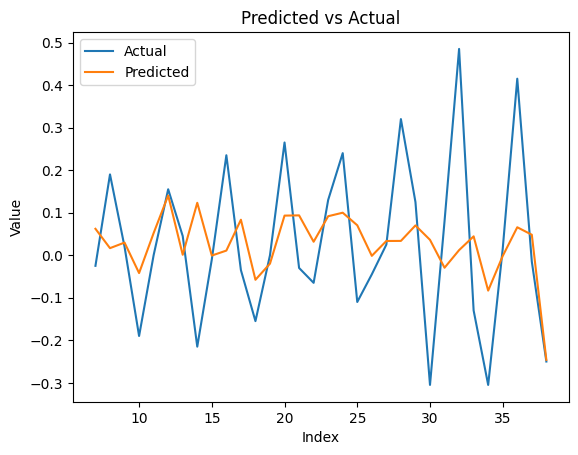

In [43]:
import matplotlib.pyplot as plt

plt.plot(y_actual.index, y_actual, label='Actual')
plt.plot(y_actual.index, y_pred, label='Predicted')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Predicted vs Actual')
plt.legend()

plt.show()

In [49]:
"""
Mean Absolute Percentage Error (MAPE) formula:
\text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_{\text{actual}, i} - y_{\text{pred}, i}}{y_{\text{actual}, i}} \right| \times 100
"""

'\nMean Absolute Percentage Error (MAPE) formula:\n\text{MAPE} = \x0crac{1}{n} \\sum_{i=1}^{n} \\left| \x0crac{y_{\text{actual}, i} - y_{\text{pred}, i}}{y_{\text{actual}, i}} \right| \times 100\n'

In [45]:
mean_error = np.mean(np.abs((y_actual - y_pred) / (y_actual+1e-6))) * 100
print(f"The MAPE when including zeros is {mean_error}")

The MAPE when including zeros is 224677.12611875354


In [46]:
df1 = pd.DataFrame({'actual': y_actual, 'predicted': y_pred})
df1 = df1[df1['actual'] != 0]
print(f"The MAPE when not including zeros is {np.mean(np.abs((df1['actual'] - df1['predicted']) / (y_actual))) * 100}")

The MAPE when not including zeros is 124.40229614055474
